## 数据预处理



In [ ]:
import os.path

train_data = open('../data/raw/sogou_rematch/user_tag_query.10W.TRAIN', 'r', encoding='gb18030')
OUTPUT_DATA_PATH = '../data/processed/query_words.train'

try:
    if os.path.exists(OUTPUT_DATA_PATH):
        os.remove(OUTPUT_DATA_PATH)

    output_data = open(OUTPUT_DATA_PATH, 'w', encoding='utf-8')

    for line in train_data:
        line_list = line.split('\t') # 以制表符分割
        line_list = line_list[4:] # 只保留查询词
        output_line = '\n'.join(line_list) # 以换行符连接
        output_data.write(output_line) # 写入文件
        
finally:
    train_data.close()
    output_data.close()

In [ ]:
import re
import os.path

OUTPUT_DATA_PATH = '../data/processed/cleaned.train'

try:
    train_data = open('../data/processed/query_words.train', 'r', encoding='utf-8')
    if os.path.exists(OUTPUT_DATA_PATH):
        os.remove(OUTPUT_DATA_PATH)

    output_data = open(OUTPUT_DATA_PATH, 'w', encoding='utf-8')

    for line in train_data:
        word_list = line.split('\t')
        pattern = re.compile('(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]')
        # 如果字符串包含网址，则跳过
        if pattern.search(word_list[0]):
            continue
        line_string = '\n'.join(word_list)
        output_data.write(line_string)
finally:
    train_data.close()
    output_data.close()

## 分词

In [ ]:
import jieba
# 读取cleaned.train文件
train_data = open('../data/processed/cleaned.train', 'r', encoding='utf-8')
output_data = open('../data/processed/seg_list.train', 'w', encoding='utf-8')
# 逐行处理
for line in train_data:
    line = line.strip()
    temp_seg_list = list(jieba.cut(line))
    # 去除空格
    temp_seg_list = [word for word in temp_seg_list if word != ' ']
    output_data.write('\n'.join(temp_seg_list))
    # 换行
    output_data.write('\n')
# 关闭文件
print('分词处理完成！')
train_data.close()
output_data.close()

## 合并停用词文件

In [ ]:
# 停用词文件路径
stopwords_file_1 = '../data/stop_words/baidu_stopwords.txt'  # 第一个停用词文件
stopwords_file_2 = '../data/stop_words/cn_stopwords.txt'  # 第二个停用词文件
output_file = '../data/stop_words/merge_stopwords.txt'  # 输出合并后的停用词文件

# 1. 读取第一个停用词文件
stopwords = set()  # 使用集合以避免重复

with open(stopwords_file_1, 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())  # 去除行首尾空白并添加到集合中

# 2. 读取第二个停用词文件
with open(stopwords_file_2, 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())  # 去除行首尾空白并添加到集合中

# 3. 将合并后的停用词写入输出文件
with open(output_file, 'w', encoding='utf-8') as file:
    for word in sorted(stopwords):  # 可选：按字母顺序排序
        file.write(word + '\n')  # 每个停用词写入一行

## 过滤词

In [ ]:
# 1. 加载停用词
stopwords_file = '../data/stop_words/merge_stopwords.txt'  # 停用词文件路径
stopwords = set()

with open(stopwords_file, 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

# 2. 读取已分词的训练数据并过滤停用词
train_file = '../data/processed/seg_list.train'  # 已分词的训练数据路径
output_file = '../data/processed/filter_list.train'  # 过滤后的训练数据路径

with open(train_file, 'r', encoding='utf-8') as train_data, \
     open(output_file, 'w', encoding='utf-8') as output_data:

    for line in train_data:
        line = line.strip()  # 去除行首尾空白
        words = line.split()  # 将分词结果按空格拆分
        # 过滤停用词
        filtered_words = [word for word in words if word not in stopwords]
        if filtered_words:  # 确保不写入空行
            output_data.write(' '.join(filtered_words) + '\n')  # 以空格连接过滤后的词


## 选取关键词

In [6]:
import time
from collections import Counter

def read_and_count_words(filename, exclude_single=True, exclude_specific=None):
    # 记录开始时间
    start_time = time.time()

    # 读取文件内容并将每一行作为一个单词
    with open(filename, 'r', encoding='utf-8') as file:
        words = [line.strip() for line in file]
    
    # 去除单个字的词语
    if exclude_single:
        words = [word for word in words if len(word) > 1]
    
    # 去除特定的词语
    if exclude_specific:
        words = [word for word in words if word not in exclude_specific]
    
    # 使用Counter来统计每个词的出现频率
    word_counts = Counter(words)
    
    # 获取出现频率最高的前20个词语
    most_common_20 = word_counts.most_common(20)
    
    # 记录结束时间
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"运行时间: {elapsed_time:.4f}秒")
    
    return most_common_20

# 调用函数，并打印结果
filename = '../data/processed/filter_list.train'  
exclude_specific = ['2016']
most_common_20 = read_and_count_words(filename, exclude_single=True, exclude_specific=exclude_specific)

# 打印出前20个最常见的词语及其频率
for word, freq in most_common_20:
    print(f'{word}: {freq}')

运行时间: 18.6463秒
图片: 291067
手机: 191439
小说: 159798
视频: 157470
下载: 134902
大全: 131461
qq: 98843
电影: 96574
中国: 94098
世界: 85064
重生: 72730
百度: 68046
官网: 66630
txt: 65481
英语: 64916
电视剧: 63333
游戏: 61142
查询: 60955
做法: 60019
一个: 59794


# 哈希+最小堆

In [7]:
import time
import heapq

def read_and_count_words(filename, exclude_single=True, exclude_specific=None):
    # 初始化一个空的计数字典
    word_counts = {}
    
    # 记录开始时间
    start_time = time.time()

    # 读取文件内容并将每一行作为一个单词
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()
            # 检查是否需要排除单个字符的单词或特定单词
            if (not exclude_single or len(word) > 1) and (exclude_specific is None or word not in exclude_specific):
                # 更新计数字典
                word_counts[word] = word_counts.get(word, 0) + 1
    
    # 创建一个大小为20的最小堆
    heap = []
    for word, count in word_counts.items():
        if len(heap) < 20:
            heapq.heappush(heap, (count, word))
        else:
            # 如果当前单词的计数大于堆顶元素，则替换它
            if count > heap[0][0]:
                heapq.heapreplace(heap, (count, word))
    
    # 将堆转换成有序列表
    most_common_20 = [(word, count) for count, word in sorted(heap, reverse=True)]
    
    # 记录结束时间
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"运行时间: {elapsed_time:.4f}秒")
    
    return most_common_20

# 调用函数，并打印结果
filename = '../data/processed/filter_list.train'  
exclude_specific = ['2016']
most_common_20 = read_and_count_words(filename, exclude_single=True, exclude_specific=exclude_specific)

# 打印出前20个最常见的词语及其频率
for word, freq in most_common_20:
    print(f'{word}: {freq}')

运行时间: 16.8643秒
图片: 291067
手机: 191439
小说: 159798
视频: 157470
下载: 134902
大全: 131461
qq: 98843
电影: 96574
中国: 94098
世界: 85064
重生: 72730
百度: 68046
官网: 66630
txt: 65481
英语: 64916
电视剧: 63333
游戏: 61142
查询: 60955
做法: 60019
一个: 59794


# 筛选含有种子关键词的搜索条目——暴力匹配

In [1]:
import time

def read_seed_words(filename):
    # 从指定文件中读取种子词
    with open(filename, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file]

def filter_items_with_seed_words(input_filename, output_filename, seed_words):
    # 创建一个字典来存储每个种子词对应的数据项
    categorized_items = {seed_word: [] for seed_word in seed_words}
    
    # 读取输入文件并分类数据项
    with open(input_filename, 'r', encoding='gbk', errors='ignore') as infile:
        for line in infile:
            items = line.strip().split()  # 使用空格分割每一行的数据项
            
            # 检查每一个数据项
            for item in items:
                for seed_word in seed_words:
                    if seed_word in item:
                        # 添加到对应的种子词列表中
                        categorized_items[seed_word].append(item)
    
    # 写入输出文件
    with open(output_filename, 'w', encoding='utf-8') as outfile:
        # 遍历每个种子词及其对应的数据项
        for seed_word, items in categorized_items.items():
            if items:
                outfile.write(f"{seed_word}::\n")
                for item in items:
                    outfile.write(f"  {item}\n")

# 主函数
if __name__ == "__main__":
    # 记录开始时间
    start_time = time.time()

    # 指定文件路径
    seed_words_file = '../data/seed_words'
    user_tag_query_file = '../data/user_tag_query.10W.TRAIN'
    output_file = '../data/seed_words_query.train'

    # 读取种子词
    seed_words = read_seed_words(seed_words_file)
    # print("读取的种子词:", seed_words)

    # 过滤并分类保存结果
    filter_items_with_seed_words(user_tag_query_file, output_file, seed_words)
    
    # 记录结束时间
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"程序运行时间: {elapsed_time:.4f}秒")
    
    # print(f"筛选后的数据已保存至 {output_file}")

程序运行时间: 14.1965秒


# 筛选含有种子关键词的搜索条目——ac自动机

In [15]:
import time
from ahocorasick import Automaton

def read_seed_words(filename):
    # 从指定文件中读取种子词
    with open(filename, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file]

def match_patterns_in_file(input_filename, output_filename, automaton):
    # 使用自动机匹配文本中的模式串，并将结果写入到新文件中
    with open(input_filename, 'r', encoding='gbk', errors='ignore') as input_file, \
         open(output_filename, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            words = line.split()  # 分割每行的单词
            for word in words:
                matches = list(automaton.iter(word))
                for end_index, (insert_order, original_value) in matches:
                    start_index = end_index - len(original_value) + 1
                    output_file.write(f"{word}\n")

# 文件路径
seed_words_file = '../data/seed_words'
user_tag_query_file = '../data/user_tag_query.10W.TRAIN'
output_file = '../data/seed_words_query_ac.train'

# 开始计时
start_time = time.time()

# 读取种子词
seed_words = read_seed_words(seed_words_file)

# 创建AC自动机实例
automaton = Automaton()

# 添加模式串到自动机中
for idx, keyword in enumerate(seed_words):
    automaton.add_word(keyword, (idx, keyword))  # 可以附加任何数据到关键词上

# 构建自动机
automaton.make_automaton()

# 匹配文件中的所有字符串并将结果输出到新文件中
match_patterns_in_file(user_tag_query_file, output_file, automaton)

# 结束计时并打印执行时间
end_time = time.time()
execution_time = end_time - start_time
print(f"程序执行时间: {execution_time:.2f} 秒")

程序执行时间: 11.40 秒


# 筛选含种子关键词的搜索条目——WM算法（不适用

In [22]:
import time

def create_bad_character_table(pattern):
    # 创建“坏字符”位移表
    bc = {}
    m = len(pattern)
    for i in range(m - 1):
        # 如果字符不在表中，则设置位移量为模式的长度减去字符的位置减一
        bc[pattern[i]] = m - i - 1
    return bc

def search_patterns_in_file(input_filename, output_filename, patterns):
    # 创建每个模式的“坏字符”位移表
    bad_char_shift = {pattern: create_bad_character_table(pattern) for pattern in patterns}
    
    with open(input_filename, 'r', encoding='gbk', errors='ignore') as input_file, \
         open(output_filename, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            text = line.strip()
            words = text.split()  # 按空格分割每行的单词
            
            for word in words:
                for pattern in patterns:
                    m = len(pattern)
                    n = len(word)
                    i = m - 1
                    while i < n:
                        j = m - 1
                        while j >= 0 and word[i] == pattern[j]:
                            if j == 0:
                                output_file.write(f"{word}\n")
                                break
                            i -= 1
                            j -= 1
                        if j > 0:  # 没有完全匹配
                            shift = bad_char_shift[pattern].get(word[i], m)
                            i += shift
                        else:
                            i += 1

# 文件路径
seed_words_file = '../data/seed_words'
user_tag_query_file = '../data/user_tag_query.10W.TRAIN'
output_file = '../data/seed_words_query_wu_manber.train'

# 开始计时
start_time = time.time()

# 读取种子词
with open(seed_words_file, 'r', encoding='utf-8') as file:
    seed_words = [line.strip() for line in file]

# 在文件中搜索模式并将结果输出到新文件中
search_patterns_in_file(user_tag_query_file, output_file, seed_words)

# 结束计时并打印执行时间
end_time = time.time()
execution_time = end_time - start_time
print(f"程序执行时间: {execution_time:.2f} 秒")

KeyboardInterrupt: 

# 画图

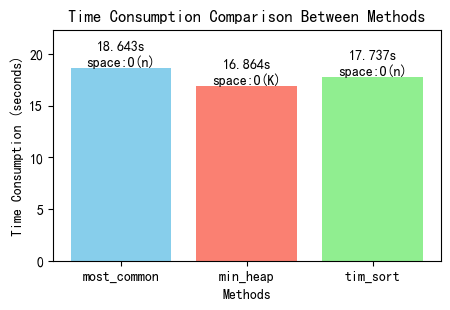

In [2]:
import matplotlib.pyplot as plt

# 更新时间消耗数据
methods = ['most_common', 'min_heap', 'tim_sort']
time_costs = [18.643, 16.864, 17.737]  # 单位秒
space_complexities = ['space:O(n)', 'space:O(K)', 'space:O(n)']  # 复杂度

# 创建柱状图
plt.figure(figsize=(5, 3))  # 增加宽度以容纳第三个条目
bar_plot = plt.bar(methods, time_costs, color=['skyblue', 'salmon', 'lightgreen'])

# 添加数值标签和空间复杂度标签
for index, value in enumerate(time_costs):
    plt.text(index, value, f'{value}s\n{space_complexities[index]}',
             ha='center', va='bottom', fontsize=10)

# 设置标题和坐标轴标签
plt.title('Time Consumption Comparison Between Methods')
plt.xlabel('Methods')
plt.ylabel('Time Consumption (seconds)')

# 调整y轴的范围以确保文本标签不会被截断
plt.ylim(0, max(time_costs) * 1.2)

# 显示图表
plt.show()

# 画图

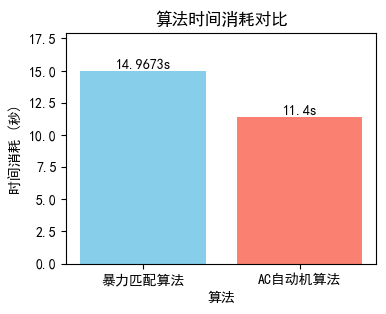

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 注册字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 时间消耗数据
algorithms = ['暴力匹配算法', 'AC自动机算法']
time_costs = [14.9673, 11.40]  # 单位秒

# 创建柱状图
plt.figure(figsize=(4, 3))
bar_plot = plt.bar(algorithms, time_costs, color=['skyblue', 'salmon'])

# 添加数值标签
for index, value in enumerate(time_costs):
    plt.text(index, value, f'{value}s',
             ha='center', va='bottom', fontsize=10)

# 设置标题和坐标轴标签
plt.title('算法时间消耗对比')
plt.xlabel('算法')
plt.ylabel('时间消耗 (秒)')

# 调整y轴的范围以确保文本标签不会被截断
plt.ylim(0, max(time_costs) * 1.2)

# 显示图表
plt.show()

# 搜索条目分词

In [10]:
import jieba

# 关键词列表
keywords = [
    "图片::", "手机::", "小说::", "视频::", "下载::", "大全::", "qq::", "电影::", "中国::", "世界::",
    "重生::", "百度::", "官网::", "txt::", "英语::", "电视剧::", "游戏::", "查询::", "做法::", "倾城::"
]
# 加载自定义词典
jieba.load_userdict('../data/dictionary')
# 去掉冒号后的关键词列表
keywords_clean = [keyword[:-2] for keyword in keywords]

# 定义一个字典来存储每个词及其对应的分词结果
word_dict = {keyword: [] for keyword in keywords_clean}

# 当前处理的关键词
current_keyword = None

# 输入文件路径
input_file_path = '../data/seed_words_query.train'
# 输出文件路径
output_file_path = '../data/seg_mid.train'

# 读取输入文件
with open(input_file_path, 'r', encoding='utf-8') as train_data:
    # 逐行处理
    for line in train_data:
        line = line.strip()
        
        # 判断是否为新关键词行
        if any(keyword == line for keyword in keywords):
            current_keyword = line[:-2]  # 去掉冒号
        else:
            # 使用搜索引擎分词模式
            seg_list = [word for word in jieba.lcut(line) if word != '']
            
            # 去掉与当前关键词相同的部分
            filtered_segs = [seg for seg in seg_list if seg != current_keyword]
            if current_keyword and filtered_segs:
                word_dict[current_keyword].extend(filtered_segs)

# 打开输出文件
with open(output_file_path, 'w', encoding='utf-8') as output_data:
    # 按词打印分词结果
    for keyword, segs in word_dict.items():
        output_data.write(f"{keyword}:\n")
        for seg in segs:
            output_data.write(f" {seg}\n")

print('分词处理完成！ seg_mid.train')

分词处理完成！ seg_mid.train


# 过滤停用词（中介）

In [13]:
# 1. 加载停用词
stopwords_file = '../data/stop_words/merge_stopwords.txt'  # 停用词文件路径
stopwords = set()

with open(stopwords_file, 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

# 2. 读取已分词的训练数据并过滤停用词
train_file = '../data/seg_mid.train'  # 已分词的训练数据路径
output_file = '../data/filter_list_mid.train'  # 过滤后的训练数据路径

with open(train_file, 'r', encoding='utf-8') as train_data, \
     open(output_file, 'w', encoding='utf-8') as output_data:

    for line in train_data:
        line = line.strip()  # 去除行首尾空白
        words = line.split()  # 将分词结果按空格拆分
        # 过滤停用词
        filtered_words = [word for word in words if word not in stopwords]
        if filtered_words:  # 确保不写入空行
            output_data.write(' '.join(filtered_words) + '\n')  # 以空格连接过滤后的词

# 选取中介关键词

In [16]:
from collections import Counter
keywords = [
    "图片:", "手机:", "小说:", "视频:", "下载:", "大全:", "QQ:", "电影:", "中国:", "世界:", 
    "重生:", "百度:", "官网:", "txt:", "英语:", "电视剧:", "游戏:", "查询:", "做法:", "倾城:"
]
# 输入文件路径
input_file_path = '../data/filter_list_mid.train'
# 输出文件路径
output_file_path = '../data/seed_mid.train'
current_keyword = None
words=[]
with open(output_file_path, 'w', encoding='utf-8') as output_data:
    pass  # 使用 'w' 模式打开文件并立即关闭，达到清空文件的目的

with open(input_file_path, 'r', encoding='utf-8') as train_data:
    # 逐行处理
    for line in train_data:
        line = line.strip()
        # 判断是否为新关键词行
        if any(keyword == line for keyword in keywords):
            if current_keyword is None:
                current_keyword = line
            else:
                word_counts = Counter(words)
                most_common_20 = word_counts.most_common(20)
                with open(output_file_path, 'a', encoding='utf-8') as output_data:
                    output_data.write(current_keyword+ '\n')
                    for word,freq in most_common_20:
                        output_data.write(f" {word}:{freq}\n")
                words.clear()
                print("clear"+current_keyword)
                current_keyword = line
                print("new"+current_keyword)
        else:
            words.append(line)
 
print(words)           
with open(output_file_path, 'a', encoding='utf-8') as output_data:
    output_data.write(current_keyword + '\n')
    word_counts = Counter(words)
    most_common_20 = word_counts.most_common(20)
    for word,freq in most_common_20:
        output_data.write(f" {word}:{freq}\n")
            

clear图片:
new手机:
clear手机:
new小说:
clear小说:
new视频:
clear视频:
new下载:
clear下载:
new大全:
clear大全:
new电影:
clear电影:
new中国:
clear中国:
new世界:
clear世界:
new重生:
clear重生:
new百度:
clear百度:
new官网:
clear官网:
newtxt:
cleartxt:
new英语:
clear英语:
new电视剧:
clear电视剧:
new游戏:
clear游戏:
new查询:
clear查询:
new做法:
clear做法:
new倾城:
['微微一笑', '微微一笑', '演员表', '微微一笑', '小说', '微微一笑', '半', '妖', '几点', '播出', '微微一笑', '电视剧', '一笑倾城', '美人', '一笑', '类似', '微微一笑', '小说', '微微一笑', 'ko', '微微一笑', '肖奈', '室友', '崔航', '微微一笑', '剧照', '微微', '一笑倾城', '播出', '时间', '张', '彬彬', '微微一笑', '图片', '微微一笑', '东方', '卫视', '重播', '时间', '东方', '卫视', '微微一笑', '重播', '时间', '张', '彬彬', '微微一笑', '微微一笑', '微微一笑', '微微一笑', '更新', '时间', '优酷', '微微一笑', '西瓜', '微微一笑', '更新', '时间', '微微', '一笑倾城', '电视剧', '微微一笑', '网络', '更新', '时间', '微微一笑', '直播', '热闻', '亲妈', '儿子', '媳妇', '一巴掌', '竟然', '直', '微微一笑', '11', '集', '微微', '一笑倾城', '演员表', '微微一笑', '韩国', '火', '微微一笑', '微微一笑', '微微一笑', '小说', '微微一笑', '郝眉', '剧照', '微微一笑', '多久', '更新', '微微一笑', '郝眉', '微微一笑', '演员表', '电视剧', '微微一笑', '集', '一共', '微微一笑', '主题曲', '原作', '微微一笑', '电视剧'